# Introduction:

In this project we use NLP techniques to extract meaningful features from text data. The notebook is organized as follows:

1. Exploratory Data Analysis
2. Data Wrangling and extraction of features from numeric, categorical and text data.



We first import all the required packages for our analysis.

In [1]:
# Importing storage libraries from google cloud.

from google.cloud import storage
client = storage.Client()

In [2]:
# Specify the name of the bucket.

bucket = client.get_bucket("foodmart_dataset")

In [3]:
import pandas as pd
blob = bucket.get_blob(f"Hotel_Reviews.csv")
bt = blob.download_as_string()
# Transform bytes to string
from io import StringIO
s = str(bt,"utf-8")
s = StringIO(s)
# Reading data in the form of a pandas dataframe.
df = pd.read_csv(s)

In [4]:
import numpy as np
import gensim # for Word2Vec, since we can check the performance of this vs. bag of words model for accuracy.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder #For one hot encoding of categorical variables
from ast import literal_eval


/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


##### As a first step, we first import the csv file to our notebook.

# The shape of the dataset:


In [5]:
df.shape

(515738, 17)

## The dataset has 515738 rows and 17 columns.

## We then convert the `Reviewer_score` to integer.

In [6]:
df['Reviewer_Score_int'] = round(df['Reviewer_Score'],0).apply(np.int64)

df.head(1)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Reviewer_Score_int
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,3


# We then look into the distribution of the `Reviewer_score_int` variable.

In [7]:
counts = df['Reviewer_Score_int'].value_counts(normalize = True)
counts

10    0.364030
8     0.213587
9     0.204992
7     0.085485
6     0.053903
5     0.046900
4     0.018296
3     0.008543
2     0.004264
Name: Reviewer_Score_int, dtype: float64

# We can plot the `Reviewer_score_int` variable to check its distribution visually.

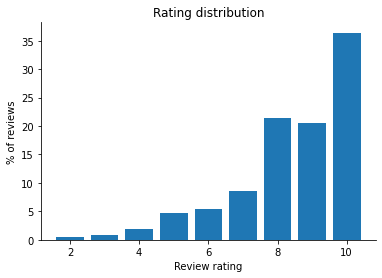

In [8]:
values, counts = np.unique(df['Reviewer_Score_int'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('% of reviews')
sns.despine()
plt.title("Rating distribution")
plt.show()

Around 57% of the reviews have a rating of above 9. The expectation was that the ratings are equally distributed across different reviews. But as we can see, the sample is highly imbalanced, hence a model build for multiclass prediction would be difficult since we have less than 5% of the reviews for a rating of 5 or below. The solution to this problem would be to convert `Reviewer_score` into a binary number of 0 and 1 where 0 indicates a positive rating while 1 indicates a negative rating.

# Part 2: Data Wrangling

#### This section is organized as follows:

1. Importing the required packages for Text Analytics.
2. Simple pre-processing of positive and negative reviews.
3. Checking for missing values and handling missing values.
4. Checking for duplicate rows and their deletion.
5. Identifying numeric and non numeric columns.
6. One Hot Encoding of non numeric columns.
7. Processing of Text Data using Bag of Words Model.



Next, we import all the required packages for text processing.

In [9]:
import nltk

In [10]:
import re #for regular expressions
import os
import csv
from nltk.stem.snowball import SnowballStemmer
import random
from nltk.classify import SklearnClassifier
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd

In [11]:
from gensim.models import Word2Vec

#### Text preprocessing of `Negative Reviews and Positive Reviews`.

In [12]:
# Preprocessing the text data


df['Negative_Review_cleaned'] = df['Negative_Review'].str.replace(r'\[[0-9]*\]', '') # Removing all numbers in between text.
df['Negative_Review_cleaned'] = df['Negative_Review'].str.replace(r'\s+', '') # Removing white spaces
df['Negative_Review_cleaned'] = df['Negative_Review'].str.replace(r'\d', '')# Removing non digit characters





/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [13]:
df['Negative_Review_cleaned'] = df['Negative_Review'].str.lower()# converts all strings to lower case.

### We repeat the same text pre-processing steps for `Postive_Reviews`.

In [14]:
df['Positive_Review_cleaned'] = df['Positive_Review'].str.replace(r'\[[0-9]*\]', '')
df['Positive_Review_cleaned'] = df['Positive_Review'].str.replace(r'\s+', '')
df['Positive_Review_cleaned'] = df['Positive_Review'].str.replace(r'\d', '')
df['Positive_Review_cleaned'] = df['Positive_Review'].str.replace(r'\s+', '')
df['Positive_Review_cleaned'] = df['Positive_Review'].str.lower()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [15]:
df.head(1)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Reviewer_Score_int,Negative_Review_cleaned,Positive_Review_cleaned
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,3,i am so angry that i made this post available...,only the park outside of the hotel was beauti...


# We now check for numeric and non numeric columns.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [17]:
# Checking for null values

df.isnull().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
Reviewer_Score_int                               0
Negative_Review_cleaned                          0
Positive_Review_cleaned        

The variable `days_since_review` is an `object` in the data. Also, it has a suffix of `days` after each number. We need to extract the numbers from this string and convert them into a integer, which can be a useful input to our model. Also we have null values in the dataset. We will deal with them later.

In [18]:
# Convert days_since_review into an integer.

df['days_since_review'] = df.days_since_review.str.extract('(\d+)') # Extracting numbers
df['days_since_review'] = df['days_since_review'].apply(np.int64)# convert the numbers into integer values.


In [19]:
# Get a dataframe of numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = pd.DataFrame(numeric_cols,columns=['Numeric_columns'])
numeric_cols


,Numeric_columns
0,Additional_Number_of_Scoring
1,Average_Score
2,Review_Total_Negative_Word_Counts
3,Total_Number_of_Reviews
4,Review_Total_Positive_Word_Counts
5,Total_Number_of_Reviews_Reviewer_Has_Given
6,Reviewer_Score
7,days_since_review
8,lat
9,lng


In [20]:
# Get a dataframe of non numeric columns
non_numeric_cols = df.select_dtypes(exclude=np.number).columns.tolist()
non_numeric_cols = pd.DataFrame(non_numeric_cols,columns=['Non_Numeric_columns'])
non_numeric_cols

,Non_Numeric_columns
0,Hotel_Address
1,Review_Date
2,Hotel_Name
3,Reviewer_Nationality
4,Negative_Review
5,Positive_Review
6,Tags
7,Negative_Review_cleaned
8,Positive_Review_cleaned


# Conversion of non numeric columns into numeric.

## We first look into the variable `Reviewer_Nationality`.


In [21]:
df['Reviewer_Nationality'].unique() # Looking athe the unique values of Reviewer_Nationality.

array([' Russia ', ' Ireland ', ' Australia ', ' United Kingdom ',
       ' New Zealand ', ' Poland ', ' Belgium ', ' Norway ', ' France ',
       ' Italy ', ' Canada ', ' Netherlands ', ' Germany ',
       ' United States of America ', ' Hungary ', ' Israel ',
       ' Switzerland ', ' India ', ' United Arab Emirates ', ' Malaysia ',
       ' Denmark ', ' South Africa ', ' Rwanda ', ' Finland ',
       ' Portugal ', ' Luxembourg ', ' Spain ', ' Malta ', ' China ',
       ' Turkey ', ' Ukraine ', ' Gibraltar ', ' Argentina ',
       ' Abkhazia Georgia ', ' Isle of Man ', ' Sweden ', ' Croatia ',
       ' Saudi Arabia ', ' Lithuania ', ' Slovenia ', ' Panama ',
       ' Austria ', ' Brazil ', ' Taiwan ', ' Iceland ', ' Iran ',
       ' Liechtenstein ', ' Chile ', ' Hong Kong ',
       ' United States Minor Outlying Islands ', ' Morocco ', ' Oman ',
       ' Lebanon ', ' Qatar ', ' Nigeria ', ' Romania ',
       ' Czech Republic ', ' Greece ', ' Thailand ', ' Singapore ',
       ' Guerns

When we look at the column `Reviewer_Nationality`, we can see some blank spaces before and after each string. For the sake of convenience, I removed all the white spaces in this column by using `str.replace` function.

In [22]:

df['Reviewer_Nationality'] = df['Reviewer_Nationality'].str.replace(r'\s+', '')# Removing blank spaces.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


### After we have removed the blank spaces in `Reviewer_nationality` we now look into the distribution of this variable.

In [23]:
Reviewer_Nationality = df['Reviewer_Nationality'].value_counts(normalize = True)
Reviewer_Nationality

UnitedKingdom             0.475524
UnitedStatesofAmerica     0.068711
Australia                 0.042048
Ireland                   0.028749
UnitedArabEmirates        0.019845
                            ...   
CapeVerde                 0.000002
NorthernMarianaIslands    0.000002
Tuvalu                    0.000002
Guinea                    0.000002
Palau                     0.000002
Name: Reviewer_Nationality, Length: 227, dtype: float64

The distribution is fairly non-uniform which United Kingdom being at the top with 47.5% of the total counts. Next is USA with 6.8% followed by Australia with 4.2%. The rest of the countries have a relatively insignificant share in the dataset. Hence it would be meaningful to divide these countries into classes, i.e. "UK", "USA", "Australia" and "Other countries".

In [24]:
# Dividing Reviewer_Nationality into classes for One Hot encoding.
conditions = [
    (df.Reviewer_Nationality == 'UnitedKingdom'),
    (df.Reviewer_Nationality == 'UnitedStatesofAmerica'),
    (df.Reviewer_Nationality == 'Australia')
]

choices = ['UK', 'USA', 'Australia']

df['Reviewer_country'] = np.select(conditions, choices, default = 'Others')


We now look at the distribution of `Reviewer_country` after the categorization. The distribution looks much better and also we have reduced the number of categories, which in turn would reduce the number of features when we do One Hot encoding.

In [25]:
Reviewer_country = df['Reviewer_country'].value_counts(normalize = True)
Reviewer_country

UK           0.475524
Others       0.413716
USA          0.068711
Australia    0.042048
Name: Reviewer_country, dtype: float64

## Next, we look into the `Hotel_Address` column.

In [26]:
df['Hotel_Address'].unique()

array([' s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands',
       '1 15 Templeton Place Earl s Court Kensington and Chelsea London SW5 9NB United Kingdom',
       '1 2 Serjeant s Inn Fleet Street City of London London EC4Y 1LL United Kingdom',
       ...,
       'Wilton Place Knightsbridge Westminster Borough London SW1X 7RL United Kingdom',
       'Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom',
       'Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 Vienna Austria'],
      dtype=object)

An interesting observation here is that every hotel address ends with the **Name of the country** in which it is located. Hence it would be useful to extract the `country name` from each hotel address. We also apply a unique() function to check the names of the countries of these hotels.

In [27]:
# Extracting the name of the country from the last string using split function.
df['countries'] = df.Hotel_Address.apply(lambda x: x.split(' ')[-1])
df.countries.unique()

array(['Netherlands', 'Kingdom', 'France', 'Spain', 'Italy', 'Austria'],
      dtype=object)

One issue we can clearly see here is that `United Kingdom` extracted only `Kingdom`, so we replace the name of this string with `UK` for the purpose of interpretation.

In [28]:
# Replacing United Kingdom with UK

df.Hotel_Address = df.Hotel_Address.str.replace('United Kingdom','UK')

In [29]:
# Checking the names of the countries again.

df['countries'] = df.Hotel_Address.apply(lambda x: x.split(' ')[-1])
df.countries.unique()

array(['Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria'],
      dtype=object)

### We now look at the distribution of these countries in which the hotels are located.

In [30]:
df['countries'].value_counts(normalize = True)

UK             0.508594
Spain          0.116627
France         0.116199
Netherlands    0.110936
Austria        0.075502
Italy          0.072143
Name: countries, dtype: float64

Most of the hotels are located in the UK, followed by Spain, France, Netherlands, Austria and Italy.

## Next, we look at the Tags column. 

This column can be particularly useful when we need to build Recommender Systems for customers while searching for hotels. For e.g. if a customer types "Leisure" and "UK", he could get a list of hotels with good and bad ratings in the UK, which are suitable for Leisure trips, from which he could choose. Hence I would choose to process this column for future purposes. Also, the `Tags` variable could be an important predictor of `Hotel Reviews`.


In [31]:
df.Tags

0         [' Leisure trip ', ' Couple ', ' Duplex Double...
1         [' Leisure trip ', ' Couple ', ' Duplex Double...
2         [' Leisure trip ', ' Family with young childre...
3         [' Leisure trip ', ' Solo traveler ', ' Duplex...
4         [' Leisure trip ', ' Couple ', ' Suite ', ' St...
                                ...                        
515733    [' Leisure trip ', ' Family with older childre...
515734    [' Leisure trip ', ' Family with young childre...
515735    [' Leisure trip ', ' Family with older childre...
515736    [' Leisure trip ', ' Group ', ' Standard Tripl...
515737    [' Leisure trip ', ' Family with young childre...
Name: Tags, Length: 515738, dtype: object

In [32]:
#function to convert array of tags to string
def impute(col):
  col = col[0]
  if (type(col) != list):
    return "".join(literal_eval(col))
  else:
    return col
#using the function
df['Tags']  = df[['Tags']].apply(impute,axis=1)


In [33]:
df.Tags

0          Leisure trip  Couple  Duplex Double Room  Sta...
1          Leisure trip  Couple  Duplex Double Room  Sta...
2          Leisure trip  Family with young children  Dup...
3          Leisure trip  Solo traveler  Duplex Double Ro...
4          Leisure trip  Couple  Suite  Stayed 2 nights ...
                                ...                        
515733     Leisure trip  Family with older children  2 r...
515734     Leisure trip  Family with young children  Sta...
515735     Leisure trip  Family with older children  2 r...
515736     Leisure trip  Group  Standard Triple Room  St...
515737     Leisure trip  Family with young children  2 r...
Name: Tags, Length: 515738, dtype: object

In [34]:
df['Tags']=df['Tags'].str.lower() # Converting each string into lower case.
df.Tags

0          leisure trip  couple  duplex double room  sta...
1          leisure trip  couple  duplex double room  sta...
2          leisure trip  family with young children  dup...
3          leisure trip  solo traveler  duplex double ro...
4          leisure trip  couple  suite  stayed 2 nights ...
                                ...                        
515733     leisure trip  family with older children  2 r...
515734     leisure trip  family with young children  sta...
515735     leisure trip  family with older children  2 r...
515736     leisure trip  group  standard triple room  st...
515737     leisure trip  family with young children  2 r...
Name: Tags, Length: 515738, dtype: object

Next, we can tokenize each row and get a list of words like "Leisure", "Duplex", "Couple", etc. We now proceed to the other columns.

## We now review the `Review_Date` column.

We extract the Year, Month and Month_year from this column. This would be helpful to detect any seasonality in the patterns of reviews.

In [35]:
# We first convert the column into Date_time format.
# Next, we extract Year, Month and Month_year from each column.


df['Review_Date'] = pd.to_datetime(df['Review_Date'])
df['year'] = pd.DatetimeIndex(df['Review_Date']).year
df['month'] = pd.DatetimeIndex(df['Review_Date']).month
df['MonthYear_value'] = df['Review_Date'].dt.to_period('M')

## We now look at missing values.

In [36]:
df.isna().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
Reviewer_Score_int                               0
Negative_Review_cleaned                          0
Positive_Review_cleaned        

Since the number of missing values (only for Lat and Long) are a very small proportion of the entire dataset (approximately 3000/500000 = 0.6%), I chose to drop the missing values from the dataset.

In [37]:
df = df.dropna()



We also look at the number of duplicate rows in the dataset.

In [38]:
# Calculating the number of duplicates.
df.duplicated().sum()

526

In [39]:
# Calculate the percentage of duplicates in the dataset.
df.duplicated().sum()/df.shape[0]

0.0010264015454563194

In [40]:
# Dropping the duplicate rows.
df = df.drop_duplicates().copy()

In [41]:
df.shape # Final shape of the dataset after dropping missing values and duplicated rows.

(511944, 25)

## Next, we look at `Hotel_Address`, `Latitude` and `Longitude` and try to extract clusters of nearby hotels for every location based on latitude and longitude.

We first create a dataframe containing `Hotel_Address`, `lat` and `lng`. In order to do this, we use a group.by function to extract latitude and longitude for each unique `Hotel_Address`.


In [42]:

# cluster hotel address based on Lat and Long
areas = df.groupby(['Hotel_Address'], as_index = False)[['lat','lng']].median()
areas

,Hotel_Address,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,52.360576,4.915968
1,1 15 Templeton Place Earl s Court Kensington a...,51.491888,-0.194971
2,1 2 Serjeant s Inn Fleet Street City of London...,51.513734,-0.108751
3,1 3 Queens Garden Westminster Borough London W...,51.514218,-0.180903
4,1 3 Rue d Argentine 16th arr 75116 Paris France,48.874348,2.289733
...,...,...,...
1471,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,48.193523,16.366915
1472,Wildpretmarkt 5 01 Innere Stadt 1010 Vienna Au...,48.210447,16.371578
1473,Wilton Place Knightsbridge Westminster Borough...,51.502091,-0.157779
1474,Wrights Lane Kensington and Chelsea London W8 ...,51.499981,-0.192879


In [43]:
df_location = areas[['lat','lng']] # For the purpose of clustering we just pick lat and lng columns.


In [44]:
from sklearn.cluster import KMeans

In [45]:
# Running the K-Means clustering Algorithm, setting the no. of clusters to 20. 
# The number of clusters was chosen arbitarily, which would be used as additional features in the dataset.
kmeans = KMeans(
    init="random",
    n_clusters=20,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [46]:
kmeans.fit(df_location) # using the Kmeans function to fit the clusters.

KMeans(init='random', n_clusters=20, random_state=42)

In [47]:
labels = kmeans.labels_

In [48]:
# Merge the clusters information into the input dataframe.
df_location['cluster'] = labels
# display the cluster no. associated with each location
df_location

,lat,lng,cluster
0,52.360576,4.915968,4
1,51.491888,-0.194971,8
2,51.513734,-0.108751,15
3,51.514218,-0.180903,8
4,48.874348,2.289733,9
...,...,...,...
1471,48.193523,16.366915,19
1472,48.210447,16.371578,19
1473,51.502091,-0.157779,3
1474,51.499981,-0.192879,8


In [49]:
# Displaying the distribution of clusters obtained from the clustering algorithm.

df_location['cluster'].value_counts()

17    150
12    125
8     107
4     105
3     103
18    101
19     98
15     93
7      91
16     88
2      83
6      74
9      72
1      48
0      41
10     38
14     25
13     21
5      11
11      2
Name: cluster, dtype: int64

Also, to further validate the clustering solution, we can plot these clusters on the map and check if each cluster represents a different geographical area. For this purpose, we need to import a module called `folium` (I first installed this on Anaconda).We can scroll the map to check all of the clusters that we obtained from the clustering algorithm.

In [50]:
#%pip install folium
import folium
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
      'beige',  'cadetblue','lightgreen','black','red', 'blue', 'green', 'purple', 'orange', 'darkred', \
      'beige',  'cadetblue','lightgreen','black','red', 'blue', 'green', 'purple', 'orange', 'darkred', \
      'beige',  'cadetblue','lightgreen','black','red', 'blue', 'green', 'purple', 'orange', 'darkred', \
      'beige',  'cadetblue','lightgreen','black','red', 'blue', 'green', 'purple', 'orange', 'darkred', \
      'beige',  'cadetblue','lightgreen','black']
lat = df_location.iloc[0]['lat']
lng = df_location.iloc[0]['lng']
map = folium.Map(location=[lat, lng], zoom_start=10)

for _, row in df_location.iterrows():
    lat=row["lat"]
    lon=row['lng']
    folium.CircleMarker(
        location=[lat, lon],
        radius=10, 
        weight=2, 
        fill=True, 
        fill_color=colors[int(row["cluster"])],
        color=colors[int(row["cluster"])]
    ).add_to(map)


In [51]:
map

The map above confirms that we have successfully divided all the `Hotel Address` in relevant clusters.

Now we add this `cluster` column into the main dataset by doing an inner join which can be achieved by applying pd.merge function.

In [52]:
df_copy = df # for merging purpose I copy the contents of my original dataframe into a new dataset.

In [53]:
df_copy = pd.merge(df_location,df,on='lat') # I merge the cluster column into the main dataset based on lat column.

All these clusters are numbers in the integer format, however since they represent each location, I convert them into string format.

In [54]:
df_copy['cluster'] = df_copy['cluster'].astype(str) # converting clusters into string format.

## We now susbet all the relevant columns for our data analysis. We also create our X and y variables.

In [55]:
df_copy['Hotel_Address'].head()

0     s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
1     s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
2     s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
3     s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
4     s Gravesandestraat 55 Oost 1092 AA Amsterdam ...
Name: Hotel_Address, dtype: object

In [56]:
X = df_copy[["Additional_Number_of_Scoring","countries","Reviewer_country","Positive_Review_cleaned",
       "Negative_Review_cleaned","days_since_review","Total_Number_of_Reviews_Reviewer_Has_Given",
       "Review_Total_Positive_Word_Counts","Total_Number_of_Reviews","Review_Total_Negative_Word_Counts",
       "Average_Score","Tags","year","month","cluster"]]
y = df_copy["Reviewer_Score_int"]


Our matrix of X has both categorical and continuous variables. Hence we need to apply One Hot encoding to all our categorical variables and drop the original categorial variables.

# One Hot encoding for `countries` of different Hotels.

In [57]:
# instantiate encoder
ohe = OneHotEncoder()

# 2D array required so store as dataframe
countries = pd.DataFrame(df_copy['countries'])

# fit and transform data
encoded = ohe.fit_transform(countries)

# interpret
encoded

dense_array = encoded.toarray()
dense_array
ohe.categories_

[array(['Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'UK'],
       dtype=object)]

In [58]:
# Put into a dataframe to get column names
countries_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

# Show
countries_df.head()

,Austria,France,Italy,Netherlands,Spain,UK
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


#### For better interpretability we rename these columns. This is because the `Reviewer_nationality` column also has different country names. So we donot want to overall `Reviewer_nationality` and `Hotel country`.

In [59]:
# Renaming the columns by adding a Hotel prefix.

countries_df.columns = ['Hotel_Austria', 'Hotel_France', 'Hotel_Italy','Hotel_Netherlands','Hotel_Spain','Hotel_UK']
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515115 entries, 0 to 515114
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Hotel_Austria      515115 non-null  int64
 1   Hotel_France       515115 non-null  int64
 2   Hotel_Italy        515115 non-null  int64
 3   Hotel_Netherlands  515115 non-null  int64
 4   Hotel_Spain        515115 non-null  int64
 5   Hotel_UK           515115 non-null  int64
dtypes: int64(6)
memory usage: 23.6 MB


# One Hot encoding of `Reviewer_country`.

In [60]:
# instantiate encoder
ohe = OneHotEncoder()

# 2D array required so store as dataframe
Reviewer_country = pd.DataFrame(df_copy['Reviewer_country'])

# fit and transform data
encoded = ohe.fit_transform(Reviewer_country)

# interpret
encoded

dense_array = encoded.toarray()
dense_array
ohe.categories_

[array(['Australia', 'Others', 'UK', 'USA'], dtype=object)]

In [61]:
# Put into a dataframe to get column names
Reviewer_country = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

# Show
Reviewer_country.head()

,Australia,Others,UK,USA
0,0,1,0,0
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0


### To differentiate from the other country columns, we add `Reviewer` as the prefix to indicate that these are Reviewer Nationalities.

In [62]:
Reviewer_country.columns = ['Reviewer_Australia', 'Reviewer_Other_countries', 'Reviewer_UK','Reviewer_USA']
Reviewer_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515115 entries, 0 to 515114
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   Reviewer_Australia        515115 non-null  int64
 1   Reviewer_Other_countries  515115 non-null  int64
 2   Reviewer_UK               515115 non-null  int64
 3   Reviewer_USA              515115 non-null  int64
dtypes: int64(4)
memory usage: 15.7 MB


# One Hot encoding of area clusters.

Here we use the One Hot Encoder to code the area clusters that we previously obtained from K-Means clustering.

In [63]:
# instantiate encoder
ohe = OneHotEncoder()

# 2D array required so store as dataframe
cluster = pd.DataFrame(df_copy['cluster'])

# fit and transform data
encoded = ohe.fit_transform(cluster)

# interpret
encoded

dense_array = encoded.toarray()

ohe.categories_

[array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
        '19', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)]

In [64]:
# Put into a dataframe to get column names
cluster = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)

# Show
cluster.head()

,0,1,10,11,12,13,14,15,16,17,18,19,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


We rename this clusters by adding the `Cluster` prefix.

In [65]:
cluster.columns = ['Cluster0','Cluster1','Cluster10','Cluster11','Cluster12','Cluster13','Cluster14',
                  'Cluster15','Cluster16','Cluster17','Cluster18','Cluster19','Cluster2',
                  'Cluster3','Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9']
cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515115 entries, 0 to 515114
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Cluster0   515115 non-null  int64
 1   Cluster1   515115 non-null  int64
 2   Cluster10  515115 non-null  int64
 3   Cluster11  515115 non-null  int64
 4   Cluster12  515115 non-null  int64
 5   Cluster13  515115 non-null  int64
 6   Cluster14  515115 non-null  int64
 7   Cluster15  515115 non-null  int64
 8   Cluster16  515115 non-null  int64
 9   Cluster17  515115 non-null  int64
 10  Cluster18  515115 non-null  int64
 11  Cluster19  515115 non-null  int64
 12  Cluster2   515115 non-null  int64
 13  Cluster3   515115 non-null  int64
 14  Cluster4   515115 non-null  int64
 15  Cluster5   515115 non-null  int64
 16  Cluster6   515115 non-null  int64
 17  Cluster7   515115 non-null  int64
 18  Cluster8   515115 non-null  int64
 19  Cluster9   515115 non-null  int64
dtypes: int64(20)
memory usage:

Finally, we concatenate all the One Hot encoded dataframes to our Main dataframe and drop the non numeric columns from our dataset. This gives us the final X-variable dataset.

In [66]:
# concatenate all dataframes into one
X = pd.concat([X, cluster, Reviewer_country, countries_df], axis=1)

# drop pre-encoded non-numeric columns
X.drop(columns=['Reviewer_country', 'countries', 'cluster','Tags'], inplace=True)

In [67]:
X.columns

Index(['Additional_Number_of_Scoring', 'Positive_Review_cleaned',
       'Negative_Review_cleaned', 'days_since_review',
       'Total_Number_of_Reviews_Reviewer_Has_Given',
       'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Negative_Word_Counts', 'Average_Score', 'year', 'month',
       'Cluster0', 'Cluster1', 'Cluster10', 'Cluster11', 'Cluster12',
       'Cluster13', 'Cluster14', 'Cluster15', 'Cluster16', 'Cluster17',
       'Cluster18', 'Cluster19', 'Cluster2', 'Cluster3', 'Cluster4',
       'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8', 'Cluster9',
       'Reviewer_Australia', 'Reviewer_Other_countries', 'Reviewer_UK',
       'Reviewer_USA', 'Hotel_Austria', 'Hotel_France', 'Hotel_Italy',
       'Hotel_Netherlands', 'Hotel_Spain', 'Hotel_UK'],
      dtype='object')

We then integrate this X dataframe(which contains all the explanatory variables) with the y dataset (which contains the binary variable 0 and 1 of the reviewer score)and create our final dataset for analysis.

In [68]:
# concatenating X and y to create our final dataframe.

df_final = pd.concat([X,y],axis=1)

# Looking at the distribution of Reviewer_Score_int 

counts = df_final['Reviewer_Score_int'].value_counts(normalize = True)
counts


10    0.364227
8     0.213457
9     0.204714
7     0.085624
6     0.053967
5     0.046943
4     0.018289
3     0.008528
2     0.004251
Name: Reviewer_Score_int, dtype: float64

The commented lines of code below help you to extract a subset of the main dataset such that all the classes of Reviewer_Score_int are included. This is useful if you are analysing this dataset on your local desktop with limited RAM. However, this subsetting would not be necessary for machines with high computing power or cloud based environments. Hence, if you are analysing this dataset on your local machine, please run the below commented lines of code to subset a smaller sample from the main dataset without losing any class of the dependent variable.

In [69]:
# Store the frequency distribution table in a new dataframe.

#new_df = pd.value_counts(df_final.Reviewer_Score_int, normalize = True).reset_index()
#new_df.columns = ['Reviewer_Score_int', 'frequency']

We now sample the dataframe such that we should extract 10% of the data from each class in `Reviewer_Score_int`.

We initiate a `for` loop for this. The list contains all the unique values of `Reviewer_Score-int`. The loop samples 10% from each class of `Reviewer_Score_int` and stores them into the empty dataframe df_sample.

In [70]:
#df_sample = pd.DataFrame(columns=df_final.columns)
#list =  new_df['Reviewer_Score_int'].tolist()
#for c in list:
#print(c)
 #   df_final_single=df_final[df_final['Reviewer_Score_int']==c]
  #  sample = df_final_single.sample(frac =.10)
   # df_sample=pd.concat([df_sample,sample])

In [71]:
# checking the final dataset df_sample

#df_sample.info()

# Converting `Reviewer_score` into a binary  variable.


In [72]:
# We now create our y_sample dataframe by converting `Reviewer_Score_int` into a binary variable.

df_final["is_Negative_review"] = df_final["Reviewer_Score_int"].apply(lambda x: 0 if x < 9 else 1)

# Creating our final X and y variables.

In [73]:
X_sample = df_final[['Additional_Number_of_Scoring', 'Positive_Review_cleaned',
       'Negative_Review_cleaned', 'days_since_review',
       'Total_Number_of_Reviews_Reviewer_Has_Given',
       'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Negative_Word_Counts', 'Average_Score', 'year', 'month',
       'Cluster0', 'Cluster1', 'Cluster10', 'Cluster11', 'Cluster12',
       'Cluster13', 'Cluster14', 'Cluster15', 'Cluster16', 'Cluster17',
       'Cluster18', 'Cluster19', 'Cluster2', 'Cluster3', 'Cluster4',
       'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8', 'Cluster9',
       'Reviewer_Australia', 'Reviewer_Other_countries', 'Reviewer_UK',
       'Reviewer_USA', 'Hotel_Austria', 'Hotel_France', 'Hotel_Italy',
       'Hotel_Netherlands', 'Hotel_Spain', 'Hotel_UK']]
y_sample = df_final['is_Negative_review']

# Splitting the dataset into test and train.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_sample,
                                                    y_sample,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y_sample)

In [104]:
# Writing the output file back to my storage bucket.

bucket.blob('Text_dataset.csv').upload_from_string(X_sample.to_csv(), 'text/csv')

## We now import CountVectorizer to analyse our text data included in `Positive Reviews` and `Negative Reviews`.

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

In [76]:
# size of training data
X_train.shape

(360580, 41)

In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360580 entries, 74013 to 132474
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Additional_Number_of_Scoring                360580 non-null  int64  
 1   Positive_Review_cleaned                     360580 non-null  object 
 2   Negative_Review_cleaned                     360580 non-null  object 
 3   days_since_review                           360580 non-null  int64  
 4   Total_Number_of_Reviews_Reviewer_Has_Given  360580 non-null  int64  
 5   Review_Total_Positive_Word_Counts           360580 non-null  int64  
 6   Total_Number_of_Reviews                     360580 non-null  int64  
 7   Review_Total_Negative_Word_Counts           360580 non-null  int64  
 8   Average_Score                               360580 non-null  float64
 9   year                                        360580 non-null  int64

### We now subset our `Positive_Reviews` and `Negative_Reviews` to run our count vectorizer.

In [78]:
PR_train = X_train['Positive_Review_cleaned']
NR_train = X_train['Negative_Review_cleaned']
PR_test = X_test['Positive_Review_cleaned']
NR_test = X_test['Negative_Review_cleaned']


## We are now ready to start with text data preprocessing which includes, stemming and lemmetization, eliminating stopwords, punctuations.

In [79]:
stemmer = nltk.stem.PorterStemmer() # For stemming

In [80]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [81]:
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## We use the customer tokenizer for text preprocessing.

In [82]:
# Building the custom tokenizer function.

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

### We also build our plotting functions to plot the most frequent words and most infrequent words obtained from our count_vectorizer.

In [83]:
# Plotting the most frequent words.
def plot_most_frequent(words, word_counts, top=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*top, 5))
    words_df.sort_values(by="count", ascending=False).head(top)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most frequent tokens")
    plt.show()
    


In [84]:
# Ploting the most infrequent words.

def plot_most_infrequent(words, word_counts, bottom=20):
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    fig, ax = plt.subplots(figsize=(0.75*bottom, 5))
    words_df.sort_values(by="count", ascending=True).head(bottom)\
        .set_index("token")\
        .plot(kind="bar", rot=45, ax=ax)
    sns.despine()
    plt.title("Most infrequent tokens")
    plt.show()

# Bag of words model

# We now initiate our CountVectorizer function using the bagofwords model.

### The main challenge here is to choose the value of min_df. So we initiate a loop starting from min_df = 5 and check for min_df = 5,10,15,20,25,50,100,500 and 1000. The objective is to look for meaningful features and also figure out the optimal number of features returned by the CountVectorizer.

In [86]:
# Initiate a for loop with different values of min_df. We store the number of features returned by each value of Min_df
# into an empty dictionary called min_df_feat. We then convert this dictionary into a dataframe for visual represenation.

list_min_df = [25,50,60,100,200,500,1000]
min_df_feat = {'Min_df':[], 'Nof':[]}
for c in list_min_df:
    
    bagofwords = CountVectorizer(min_df=c, 
                             tokenizer=my_tokenizer)
    bagofwords.fit(PR_train)

    PR_train_transformed = bagofwords.transform(PR_train)
    
    min_df_feat['Min_df'].append(c)
    min_df_feat['Nof'].append(PR_train_transformed.shape[1])
    

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [87]:
# Converting the min_df_feat dictionary into a dataframe.

Min_df_selection_PR = pd.DataFrame.from_dict(min_df_feat)
Min_df_selection_PR

,Min_df,Nof
0,25,3606
1,50,2538
2,60,2322
3,100,1798
4,200,1272
5,500,746
6,1000,461


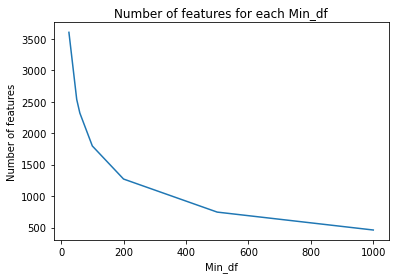

In [88]:
# Plotting the Min_df_selection_PR dataframe to analyse the optimal number of features.

plt.figure()
plt.plot(Min_df_selection_PR['Min_df'], Min_df_selection_PR['Nof'])
plt.xlabel('Min_df')
plt.ylabel('Number of features')
plt.title('Number of features for each Min_df')
plt.show()

## The above plot indicates that there is a sharp reduction in the number of features at min_df = 200. Hence we choose min_df = 200 as the optimal value for Positive Reviews. 

# We now fit the final bagofwords model for positive reviews with min_df = 200 and get the sparse matrix.

In [90]:
# Final model with min_df = 25
bagofwords = CountVectorizer(min_df=200, 
                             tokenizer=my_tokenizer)
bagofwords.fit(PR_train)

PR_train_transformed = bagofwords.transform(PR_train)
PR_test_transformed = bagofwords.transform(PR_test)

PR_feature = bagofwords.get_feature_names()
PR_train_transformed.shape

(360580, 1272)

## We look at the most frequent and most infrequent words to check if they are meaningful and relevant in our context. For this we use the plotting function we already created.

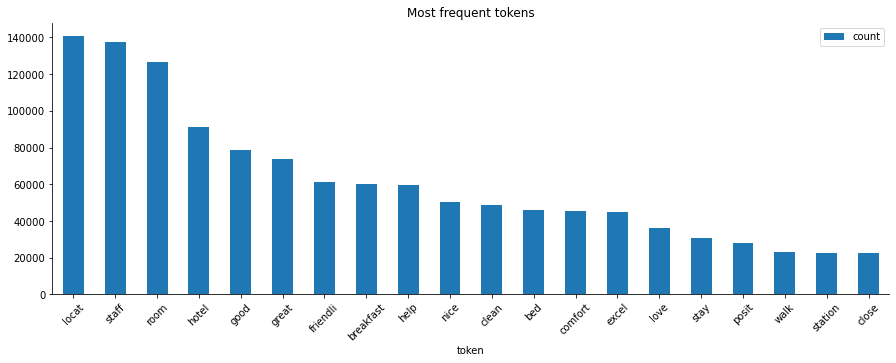

In [91]:
words = PR_feature
word_counts = PR_train_transformed.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

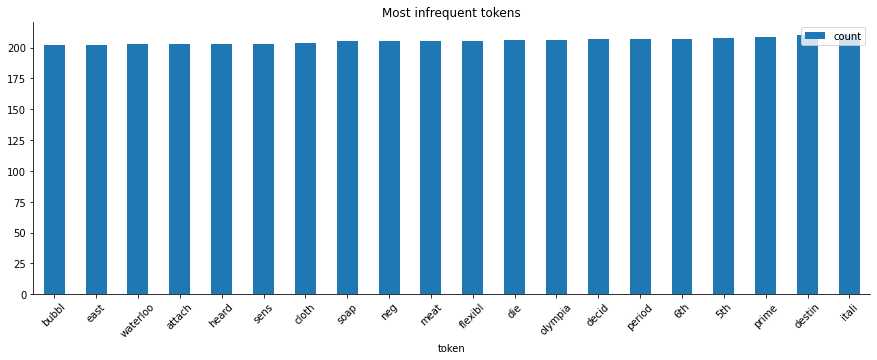

In [92]:
words = PR_feature
word_counts = PR_train_transformed.toarray().sum(axis=0)

plot_most_infrequent(words, word_counts)

# Creating the feature matrix for `Negative Reviews`.

### We now repeat the entire procedure as shown above to create the feature matrix for Negative_Reviews.

In [93]:
# Iterating over different values of Min_df and checking the number of features returned by each Min-df.

list_min_df_NR = [100,200,300,500,600,1000]
min_df_feat_NR = {'Min_df':[], 'Nof':[]}
for c in list_min_df_NR:
    
    bagofwords = CountVectorizer(min_df=c, 
                             tokenizer=my_tokenizer)
    bagofwords.fit(NR_train)

    NR_train_transformed = bagofwords.transform(NR_train)
    
    min_df_feat_NR['Min_df'].append(c)
    min_df_feat_NR['Nof'].append(NR_train_transformed.shape[1])

In [94]:
# Creating a dataframe showing different number of features for each value of Min_df.

Min_df_selection_NR = pd.DataFrame.from_dict(min_df_feat_NR)
Min_df_selection_NR

,Min_df,Nof
0,100,2227
1,200,1559
2,300,1244
3,500,947
4,600,843
5,1000,553


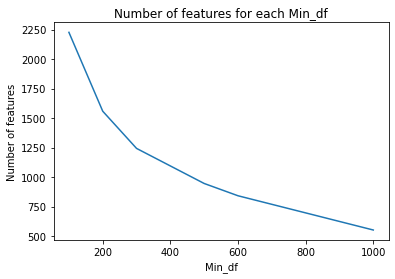

In [95]:
# Plotting the above dataframe to show the number of features against each value of Min_df.

plt.figure()
plt.plot(Min_df_selection_NR['Min_df'], Min_df_selection_NR['Nof'])
plt.xlabel('Min_df')
plt.ylabel('Number of features')
plt.title('Number of features for each Min_df')
plt.show()

## Looking at the above plot, we can see a sharp reduction in the number of features at min_df approximately equal to 400. Hence I chose Min_df = 400 for negative reviews.

In [96]:
#Fitting the final model for Negative Reviews with Min_df = 400.

bagofwords = CountVectorizer(min_df=400, 
                             tokenizer=my_tokenizer)
bagofwords.fit(NR_train)

NR_train_transformed = bagofwords.transform(NR_train)
NR_test_transformed = bagofwords.transform(NR_test)
NR_feature = bagofwords.get_feature_names()

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


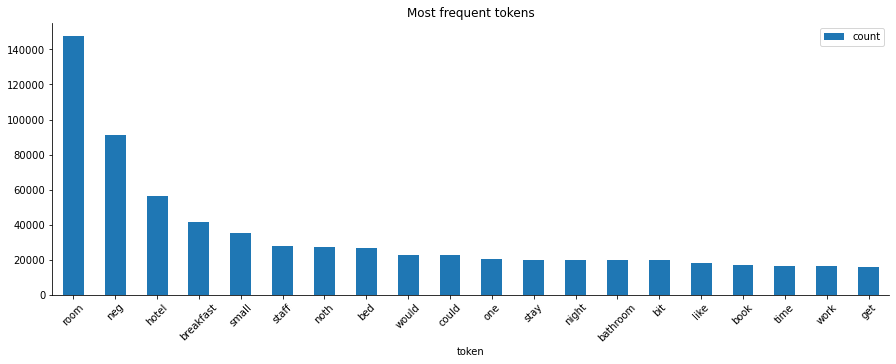

In [97]:
# Plotting the most frequent words.

words = NR_feature
word_counts = NR_train_transformed.toarray().sum(axis=0)

plot_most_frequent(words, word_counts)

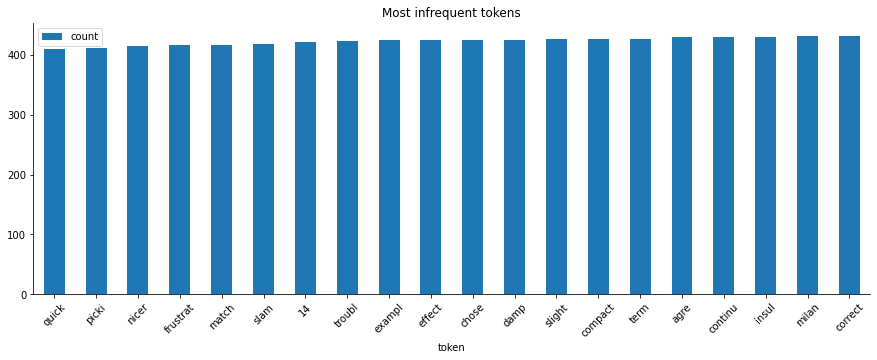

In [98]:
# Plotting the most infrequent words.

words = NR_feature
word_counts = NR_train_transformed.toarray().sum(axis=0)

plot_most_infrequent(words, word_counts)

# We now convert all our sparse matrices to dense arrays, which can then be converted into a dataframe and concatenated to our main dataset containing the numeric columns.

In [99]:
# Convert all the sparse matrices to dense arrays.

NR_train_transformed = NR_train_transformed.toarray()
PR_test_transformed = PR_test_transformed.toarray()
PR_train_transformed = PR_train_transformed.toarray()
NR_test_transformed = NR_test_transformed.toarray()

In [100]:
type(NR_test_transformed)

numpy.ndarray

In [101]:
# Convert all the dense arrays into a dataframe to get column names

PR_test_transformed = pd.DataFrame(columns=PR_feature, data=PR_test_transformed)
NR_test_transformed = pd.DataFrame(columns=NR_feature, data=NR_test_transformed)
PR_train_transformed = pd.DataFrame(columns=PR_feature, data=PR_train_transformed)
NR_train_transformed = pd.DataFrame(columns=NR_feature, data=NR_train_transformed)


# As a final step, we now concatenate all our transformed dataframes obtained above to our final X_train dataset which also includes numeric columns.

In [102]:
X_train_new = pd.concat([X_train.reset_index(),PR_train_transformed, NR_train_transformed], axis=1).drop(columns=['index','Positive_Review_cleaned','Negative_Review_cleaned'])
X_test_new = pd.concat([X_test.reset_index(),PR_train_transformed, NR_train_transformed], axis=1).drop(columns=['index','Positive_Review_cleaned','Negative_Review_cleaned'])

In [103]:
X_test_new.head(1)

,Additional_Number_of_Scoring,days_since_review,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews,Review_Total_Negative_Word_Counts,Average_Score,year,month,Cluster0,...,worn,wors,worst,worth,would,wrong,ye,year,yet,young
0,256.0,699.0,27.0,2.0,1330.0,78.0,8.2,2015.0,9.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# TFIDF vectorizer

Now we shall see how to apply TFIDF vectorizer to the above dataset to extract the features from the positive and negative reviews.

In Bag of Words model, all the words are given equal weightage, and the features extracted are based on count or frequency of each word.There is no emphasis on positive words. In this process we may miss out on the more important words which are more important from a business analysis perspective. This drawback is solved by the Term Frequency Inverse Document frequency model.

Term frequency indicates the proportion of times a word occurs in a document where as Inverse document frequency indicates the log inverse of number of documents divided by the number of documents containing the word. Hence it gives a higher weightage to the most significant words in the document, rather than just looking at the frequency of words.